In [1]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
import pickle
import argparse
from huggingface_hub import login
from google.colab import userdata
from google.colab import drive
import pandas as pd
import gc
import numpy as np
import matplotlib.pyplot as plt

drive.mount('/content/drive')
hf_token = userdata.get('hf')
login(token=hf_token)

Mounted at /content/drive


In [2]:
def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

# Initialize model

In [3]:
model_name = "meta-llama/Llama-3.1-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True
)
cleanup()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

# Download Dataset

In [4]:
data = pd.read_json("/content/drive/MyDrive/m1p/SubtaskA.jsonl", lines=True)
data = data.iloc[:, :4]

print(data.head())

label_1 = data[data['label'] == 1].head(200)
label_0 = data[data['label'] == 0].head(200)

smpl_data = pd.concat([label_1, label_0])
cleanup()

                                                text  label source   model
0  We consider a system of many polymers in solut...      1  arxiv  cohere
1  We present a catalog of 66 YSOs in the Serpens...      1  arxiv  cohere
2  Spectroscopic Observations of the Intermediate...      1  arxiv  cohere
3  We present a new class of stochastic Lie group...      1  arxiv  cohere
4  ALMA as the ideal probe of the solar chromosph...      1  arxiv  cohere


# Metrics and function for calculations

In [8]:
def calculate_entropy(logprobs):
    entropies = []
    for s_lp in logprobs:
        entropies.append([])
        for lp in s_lp:
            mask = ~np.isinf(lp)
            entropies[-1].append(-np.sum(np.array(lp[mask]) * np.exp(lp[mask])))
    return entropies

def calculate_perplexity(token_logprobs):
    N = len(token_logprobs)
    sum_logprobs = np.sum([np.max(logprobs) for logprobs in token_logprobs])
    avg_logprobs = sum_logprobs / N
    perplexity = np.exp(-avg_logprobs)
    return perplexity


def get_logits(text, model, tokenizer):
    inputs = tokenizer(text, truncation=True, max_length=512, return_tensors="pt")

    with torch.no_grad():
        outputs = model(
            **inputs
            )
    logits = outputs.logits[0]
    logits, _ = torch.topk(logits, k=256, dim=-1)
    probs = F.softmax(logits, dim=-1)

    log_probs = torch.log(probs)

    return np.array(log_probs)

def add_metrics_to_dataframe(balanced_data, model, tokenizer):
    mean_entropies, perplexities = [], []

    for text in balanced_data['text']:
        log_probs = get_logits(text, model, tokenizer)

        entropies = calculate_entropy(log_probs)
        mean_entropy = np.mean(entropies)
        perplexity = calculate_perplexity(log_probs)

        mean_entropies.append(mean_entropy)
        perplexities.append(perplexity)

    balanced_data['mean_entropy'] = mean_entropies
    balanced_data['perplexity'] = perplexities

    return balanced_data

# Calculating metrics

In [9]:
balanced_data = add_metrics_to_dataframe(smpl_data, model, tokenizer)

cleanup()

# Show results

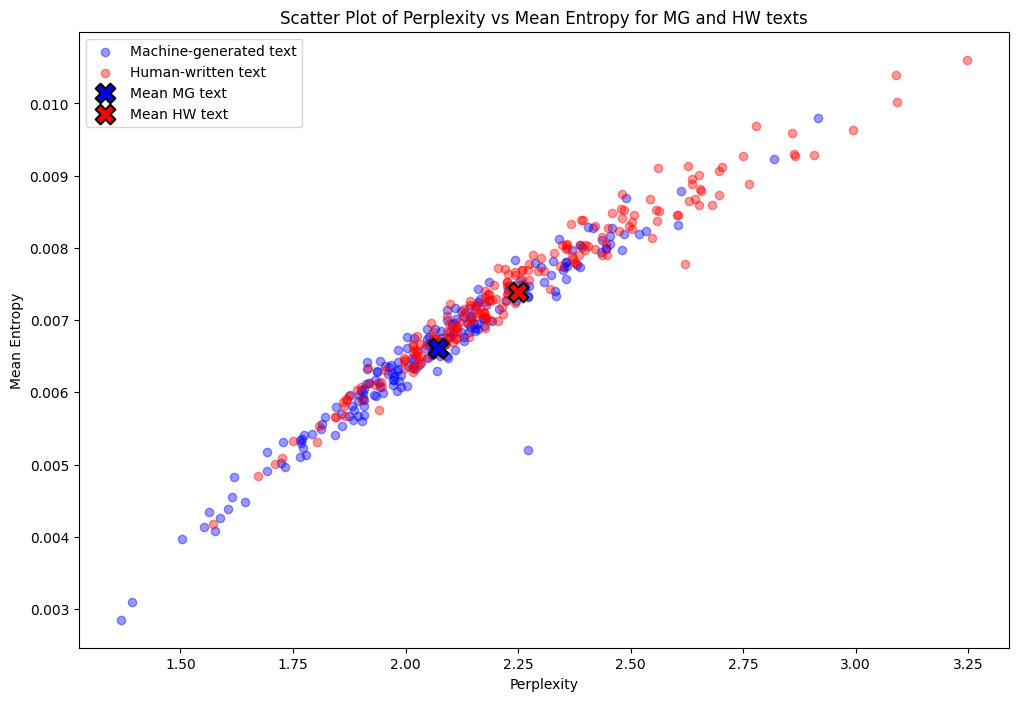

In [12]:
plt.figure(figsize=(12, 8))

label_1_data = balanced_data[balanced_data['label'] == 1]
label_0_data = balanced_data[balanced_data['label'] == 0]

plt.scatter(
    label_1_data['perplexity'],
    label_1_data['mean_entropy'],
    color='blue',
    label='Machine-generated text',
    alpha=0.4
)

plt.scatter(
    label_0_data['perplexity'],
    label_0_data['mean_entropy'],
    color='red',
    label='Human-written text',
    alpha=0.4
)

mean_perplexity_1 = label_1_data['perplexity'].mean()
mean_entropy_1 = label_1_data['mean_entropy'].mean()

mean_perplexity_0 = label_0_data['perplexity'].mean()
mean_entropy_0 = label_0_data['mean_entropy'].mean()

plt.scatter(
    mean_perplexity_1,
    mean_entropy_1,
    color='blue',
    label='Mean MG text',
    marker='X',
    s=200,
    edgecolor='black',
    linewidths=1.5
)
plt.scatter(
    mean_perplexity_0,
    mean_entropy_0,
    color='red',
    label='Mean HW text',
    marker='X',
    s=200,
    edgecolor='black',
    linewidths=1.5
)

plt.xlabel('Perplexity')
plt.ylabel('Mean Entropy')
plt.title('Scatter Plot of Perplexity vs Mean Entropy for MG and HW texts')
plt.legend()
plt.show()

cleanup()

We observe that the distribution of average machine-generated text and human-generated text differs. Whether this is a coincidence or a pattern, we will find out later...

